# Recommender System for Amazon Items
<img src="./img/amazon.png" alt="Drawing" style="width: 200px;"/>

## 1. Intro
E-commerce, an activity of buying or selling items (products) on online services, has been populated. We cannot deny that Amazon is one of the biggiest E-commerce company. From the millions items in online stores, it is hard to believe which item would be the best for customers. The given information of reviews and ratings from other customers help, but a recommender system assist to make a better and smart decision. 

## 2. Dataset
The [dataset](https://nijianmo.github.io/amazon/index.html) includes reviews "ratings-only" (ratings, text, helpfulness votes) as a csv file and item metadata "5-core" (descriptions, category information, price, brand, and image features) as a json file. The dataset is categorically divided; for this project, category of **Video Games** was chosen. For the practical prupose, item metadata of json file was loaded. 

> "5-core" (i.e., dense subsets): These data have been reduced to extract the 5-core, such that each of the remaining users and items have 5 reviews each.

**Sample review**:
{
  "reviewerID": "A2SUAM1J3GNN3B",
  "asin": "0000013714",
  "reviewerName": "J. McDonald",
  "vote": 5,
  "style": {
    "Format:": "Hardcover"
  },
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  "overall": 5.0,
  "summary": "Heavenly Highway Hymns",
  "unixReviewTime": 1252800000,
  "reviewTime": "09 13, 2009"
}

where

- reviewerID: ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin: ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- vote: helpful votes of the review
- style: a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewText: text of the review
- overall: rating of the product
- summary: summary of the review
- unixReviewTime: time of the review (unix time)
- reviewTime: time of the review (raw)
- image: images that users post after they have received the product


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from recommender_metrics import RecommenderMetrics as rm
import surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split


In [2]:
!pwd

/Users/Jae/Google_Drive_jae0325/DATA_SCIENCE/Portfolio/Amazon_product


In [3]:
## import data
pklpath = "./ecommerce/datafiniti-consumer-reviews-of-amazon-products/rating_124.pkl" #--- NON Stemmed Reviews
rating_124 = pd.read_pickle(pklpath)

#Deleting all the duplicates having the same userID, Profile, NameTime and Text all in the same column.
cleaned_rating_124 =  rating_124.drop_duplicates(subset={"reviewerID","asin","reviewTime","reviewText"},keep="first")

print('Total Length: {}, Unique user Length: {}, Unique item Length: {}\n'.format(
                                            len(cleaned_rating_124),
                                            len(cleaned_rating_124['reviewerID'].unique()),
                                            len(cleaned_rating_124['asin'].unique())))
cleaned_rating_124.head(3)

Total Length: 49535, Unique user Length: 23789, Unique item Length: 241



,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,verified,vote,month,year
12457,B0009VXBAQ,5.0,exactly as expected. no complaints!,2018-04-06,A34S5KKOKVXHUE,Alyse,5 stars,True,0,4,2018
12458,B0009VXBAQ,5.0,I really like the games from the WII and the w...,2018-04-02,A2Q731BIYCQ60C,xander,"great game console, nintendo's original games ...",True,0,4,2018
12459,B0009VXBAQ,5.0,Loved it but it has so few games!,2018-03-25,A1J8UQNUTU6B9S,Clarissa Arnot,Five Stars,True,0,3,2018


In [4]:
# ## randomly choose 30000 data
# cleaned_rating_39 = cleaned_rating_39.sample(n=30000, random_state=0)
# print('Total Length: {}, Unique user Length: {}, Unique item Length: {}\n'.format(
#                                             len(cleaned_rating_39),
#                                             len(cleaned_rating_39['reviewerID'].unique()),
#                                             len(cleaned_rating_39['asin'].unique())))

In [5]:
## Read the dataset
amazon_ratings_124 = cleaned_rating_124[['reviewerID', 'asin', 'overall']].reset_index(drop=True)
reader = Reader(rating_scale=(1, 5))
data_124 = Dataset.load_from_df(amazon_ratings_124, reader)
data_124

In [6]:
## train test datasets split
train_set, test_set = train_test_split(data_124, test_size=0.3,random_state=0)

## 3. Recommender System
A recommender system is a technique to suggest the relevant items to users, based on their preference. There are 3 types; 1) content-based filtering, 2) collaborative filtering, 3) hybrid systems. 
<center>
<img src="./img/type.png" alt="Drawing" style="width: 400px;"/>
</center>

### 3.1 Content-based Filtering (CBF) System
Content-based Filtering is a learning system to recommend by analyzing the feature similarity among items. For instance, based on user's actual ratings for different genre of movies, the system will learn to recommend the genre which is positively rated by the user. 
<center>
<img src="./img/content-based.png" alt="Drawing" style="width: 200px;"/>
</center>

To measure the similarity between items, various different similarity metrics can be used. Practically, the items in the current amazon data with meta information can be analyzed to extract features like sentiment score, rating score, or TF-IDF score for finding the similarity relationship among the items. However, the more features, the more dimensions we need; due to the curse of dimensionality, features should be well defined as well as similarity metrics. 

<center>
<img src="./img/sim_rel.png" alt="Drawing" style="width: 400px;"/>
</center>

The popular CBF is 1) Vectorization + Similarlity and 2) TF-IDF. The first method is that the vectorized item can be found similar relationship via similarity metrics, the second one is based on weighing TF (Term-Frequency; number of specific terms that appeared in specific doc) and the specialized terms that appears only specific documents via DF (number of docs that specific terms appeared) because TF does not proportional to importance so it is needed to penaltize the TF.

- Pros of CBF
    - User Independence: compared to user-based CF which needs other user's information, CBF needs only single user's profile. It has a less computations and may perform better if extracting features for similarity between items is well done.
    - Transparency on Feature-Level: it is clear that CBF based on selected features while user-based CF needs other users' interactions. 
    - Less Cold Start: CF usually faces with Cold Start that if other users have no information related to items. However, CBF has no Cold Start if current user has information like transaction history or rating history.
    
- Cons of CBF
    - Limited Content Analysis: the less information, the less accuate the recommendation (prediction) would be. 
    - Over-specialization: User may want some new experience (can be measured by novelty), but it is not great that recommended items would be expected all the time. 
    
NOTE: Similarity Metrics can be used by both CBF and Memory-based CF for neighboring. 
#### Similarity Metrics
There are Cosine, MSD (Mean Squared Difference), Pearson (Pearson correlation coefficient), and many other metrics.

### 3.2 Collaborative Filtering (CF) System
Unlike content-based CF use explicit features such as genre of movies, it is hard to extract important features in most cases with tenmendous amount of data. Then, user-item matrix is simply a starting point to grasp a pattern between users and items. The following figure shows user-item matrix.

<center>
<img src="./img/user_item_mat.png" alt="Drawing" style="width: 400px;"/>
</center>

Suppose that items shown above are movie titles. User Alice have rated item 1 to item 4 in the range of [1,5] range, but item 5 (the orange cell in the figure). This matrix helps vectorizing the users' preferences and items' features. Then, how to suggest the movie to individuals based on personal preferance? 

There are two main appraoches to CF: Model-based and Memory-based. Model-based CF (Latent Factor CF) is based on Factorization of features for users and items while Memory-based CF (neighborhood CF) is based on neighboring an object. If this object is user, the system (called user-based CF) learns the preference similarity between current user and the other users to recommend items. If the object is item, the system (called item-based CF) learns the interactions between items from current user's "behavior". 

<center>
<img src="./img/model_memory.png" alt="Drawing" style="width: 400px;"/>
</center>

> NOTE: Content-based filtering learns **content** of items to find the similarity while item-based CF learns **user behavior** on the items with meta data of current users' interactions through transaction history, ratings, selection (wish-list) information. 

#### 3.2.1 Model-based CF
The most popular model-based CF is SVD, which was used for Netflix competition 2009. SVD vectorizes preferences of users and features of items into two latent vectors; user latent and item latent. This separation is called Matrix Factorization. From the separation, users and items can be projected in a smaller dimension space (dimensionality reduction) to observe preference of users on features of items. These projected users and items should be grouped (clustering). 

Real world data is often jointly interacted between multiple entities. However, here we are intereted in two entities; users and items, which means the user-item matrix has join interaction between users and items. For instance, user 1 rating item 1 is affected by both the preference of user 1 (affinity to some subjects/categories) and the feature of item 1 (its caracteristic belongs to some subjects/categories); called bimodel. Based on similarity of these pairwise interactions, co-clustering (grouping user side and item side simutaneously) is the main poin in Model-based CF.  

Co-clustering works well especially for when pairwise interactions is sparse. Suppose that user 1 and user 2 have similar affinity to same youtube categories. It is clear that user 1 and 2 will watch the same youtube clip becuase copious amount of clips is generated daily. Then the user-item matrix have sparse interactions. In this case, clustering similar users (user-based CF in neighboring) or clustering similar items (item-based CF in neighboring) is not useful for recommendation. When co-clustering overshadow regular unimodel clustering. 

##### 3.2.1.1 SVD + SGD
SVD ,a matrix factorization, vectorize preferences of users and features of items into user latent ($U$) and item latent ($\Sigma V^T$) (more concisely $U\sqrt{\Sigma}$ and $\sqrt{\Sigma}V^T$). 

<center>
<img src="./img/svd.png" alt="Drawing" style="width: 400px;"/>
</center>

The user latent factor and item latent factor with $\Sigma}$ which represents significance of those factors. This helps the singular values compressed the representation by $k$. In factorization, $k$, which is an adjustable number of features to describe preference of users for subjects/categories and features of items belongs to subjects/categories, can be selected to vertorize users and items with important features (largest singular values), ignoring the rest. It is called Truncated SVD. 

Estimated rating $\hat{r}_(u,i)$ is defined as following:
$$\hat{r}_(u,i) = U_u\cdot V_i^T$$
> NOTE: It may be confusing that I used $U$ and $V$ for user latent and item latent, but to be accurate, $U$ is actually $U\sqrt{\Sigma}$, and $V$ is $\sqrt{\Sigma}V^T$.

However, bias can be added to avoid overfitting.

$$\hat{r}_(u,i) = U(u)\cdot V(i)^T + \mu + b(u) + b(i)$$

Where $\hat{r}(u,i)$ is estimated rating from user u for item i, $U(u)$ user vector ($1\times k$), $V(i)$ item feature vector ($1\times k$), and $\mu$ is mean of all the actual ratings, $b(u)$ is user bias, and $b(i)$ is item bias.

For better optimization, loss function can be the following. 

$$\min_{U,V}L = \frac{1}{2} \sum_{u,i \in R_{train}} (r(u,i)-\hat{r}(u,i))^2 + \lambda (b(u)^2 + b(i)^2 + ||U_u||^2 + ||V_i||^2)$$

Note that $U_u \cdot V_i^T = <U_u,V_i> = \sum_{s=1}^k u_{us}v_{is}$

The system learns how to predict unknown ratings by fitting the past observed actual ratings and penaltizing the squared magnitude of latent matrix U and V with $\lambda$.

The minimization can be solved by using SGD (Stochastic Gradient Descent). The error $e(u,i)$ modifies the parameters of $U$ and $V$ by a magnitude proportional to $\lambda$ in opposite direction of the gradient, minimizing the loss function $L$. 

$$L = \frac{1}{2} e(u,i)^2 + \frac{1}{2} (||U_u||^2 + ||V_i||^2 + b(u)^2 + b(i)^2$$

Where $e(u,i) = r(u,i) - U_u \cdot V_i^T$.

Gradient updates: 
$$\frac{\partial}{\partial U_u}L(U,V) = e(u,i)(-V_i^T)+\lambda ||U_u||$$
$$\frac{\partial}{\partial V_i}L(U,V) = e(u,i)(-U_u^T)+\lambda ||V_i||$$

Bias updates: 
$$b(u) \leftarrow b(u) + \eta (e(u,i) - \lambda b(u))$$
$$b(i) \leftarrow b(i) + \eta (e(u,i) - \lambda b(i))$$

User and Item latent matrix updates:
$$U_u \leftarrow U_u - \eta \frac{\partial}{\partial U_u}L(U,V)$$
$$V_i \leftarrow V_i - \eta \frac{\partial}{\partial V_i}L(U,V)$$

This process repeated until $L$ converges. 

##### 3.2.1.2 SVD + ALS 
Back to minimization of $L$, we have $L$ added with regularization (penalty) term to avoid overfitting. However, this addition makes the loss function non-convex. ALS is the idea of using only the error term $r(u,i)-<U_u,V_i>$ in linear regression if we fix one side. This error term can be expressed as $y - X\beta$. Then, we can find $\beta$ by solving $\beta=(X^TX)^{-1}X^Ty$. 

As a reminder, we need to cluster user latent $U$ and item latent $V$. With fixed $V$, we can modulate $U$. Now, we can modulate $V$ with fixed $U$. This repeatative process works alternatively until the loss converges. 

> NOTE: since linear regression solution is unique and guarantees a minimal MSE, loss function never increases (either decreases or stays the same). Thus, convergence works. 

Loss function for user latent and item latent.

$$L(U_u) = ||e(u)||^2 + \lambda ||U_u||^2 $$

$$L(V_i) = ||e(i)||^2 + \lambda ||V_i||^2 $$

Where $e(u) = R_u - <U_u, V>$, $e(i) = R_i - <U, V_i>$; $e(u)$ is the error for user u's rating over all the items such that $R_u$ is a rating vector of user u from $R$. Similarly, $e(i)$ is the error for item i's rating by all the users such that $R_i$ is a rating vector of item i from $R$.

Modulate user latent $U$ with constant (considered) fixed item latent $V$ 
$$U_u = ((V^T\cdot V + \lambda I)^{-1}V^T \cdot R_u^T)^T$$

Modulate item latent $V$ with constant (considered) fixed user latent $U$ 
$$V_i = ((U^T\cdot U + \lambda I)^{-1}U^T \cdot R_i^T)^T$$

Since the unknown r(u,i) should be replaced by 0 and not be computed for loss, the modified loss function $L$ is follwing:

$$L = \sum_{u}w_{u,i}||r(u,i) - U_u \cdot V_i^T||^2 + \lambda (||U_u||^2+||V_i||^2)$$

Where $w_{u,i}$ is 1 if $r(u,i)!=0$ (actual rating is known), $w_{u,i}$ is 0 if $r(u,i)==0$ (actual rating is unknown). 

User latent $U$ updates with constant $V$:
$$U_u \leftarrow ((V^T\cdot w_u V + \lambda I)^{-1}V^T \cdot w_u R_u^T)^T$$
$$U_u \leftarrow \sum_{u,i \in R_{train}}(V_i^T\cdot w_u V_i + \lambda I_k)^{-1}\sum_{u,i \in R_{train}} r(u,i)V_i$$

User latent $V$ updates with constant $U$:
$$V_i \leftarrow ((U^T\cdot w_i U + \lambda I)^{-1}U^T \cdot w_i R_i^T)^T$$
$$V_i \leftarrow \sum_{u,i \in R_{train}}(U_u^T\cdot w_i U_u + \lambda I_k)^{-1}\sum_{u,i \in R_{train}} r(u,i)U_u$$

For the computional cost, $O(n_u \cdot k^2 + k^3)$ for $U_u$ update where $n_u$ is the number of actual ratings of user u. Similarly, $O(n_i \cdot k^2 + k^3)$ for $V_i$ update where $n_i$ is the number of actual ratings of item i by users. It means that the cost for estimatng r(u,i) is $O(nmk)$.

#### 3.2.2 Memory-based CF
Memory-based CF has user-based CF and item-based CF. 
User-based CF finds similar users via transaction history or rating patterns and recommends the item that current user has not purchased or rated. On the other hand, Item-based CF learns similarity patterns between items with meta inforamtion and recommends similar items to current user. The following figure shows the difference between user-based CF and item-based CF.

<center>
<img src="./img/userB_itemB.png" alt="Drawing" style="width: 400px;"/>
</center>

##### 3.2.2.1 KNN

The basic neighboring algorithm is KNN (K-Nearest Neighbors). Depending on object's definition, one specific object finds k nearest neighbors and similar objects to the current one can be determined for recommendation. 

<center>
<img src="./img/knn.png" alt="Drawing" style="width: 250px;"/>
</center>

If the object is defined as user, the system finds k number of similar users surrounded by current one and recommends the items that current user hasn't purchase but other similar users bought. Similarly, if the object is defined as item, the system finds k number of similar items that current user hasn't bought and recommends the items. The type of similarity metric affects the performance. The following shows formulae for user-based vs. item-based. 

1. Cosine
For similarity between user u and v
$$cosine\_sim(u,v) = \frac{\sum_{i\in I(u,v)} r(u,i) \cdot r(v,i)}{\sqrt{\sum_{i\in I(u,v)} r(u,i)^2}\cdot {\sqrt{\sum_{i\in I(u,v)} r(v,i)^2}}}$$

Where $I(u,v)$ is the item set for user u and v, $r(u,i)$ is actual rating that user u gave item i, and $r(v,i)$ is actual rating from user v for item i.

For similarity between item i and j
$$cosine\_sim(i,j) = \frac{\sum_{u\in U(i,j)} r(u,i) \cdot r(u,j)}{\sqrt{\sum_{u\in U(i,j)} r(u,i)^2}\cdot {\sqrt{\sum_{u\in U(i,j)} r(u,j)^2}}}$$

Where $U(i,j)$ is the user set for item i and j, $r(u,i)$ is actual rating that user u gave item i, and $r(u,j)$ is actual rating from user u for item j.

2. MSD (Mean Squared Distance)
For similarity between user u and v
$$msd\_sim(u,v) = \frac{1}{\frac{1}{|I(u,v)|\cdot \sum_{i\in I(u,v)} (r(u,i)-r(v,i))^2}+1}$$

Where $I(u,v)$ is the item set for user u and v, $r(u,i)$ is actual rating that user u gave item i, and $r(v,i)$ is actual rating from user v for item i.

For similarity between item i and j
$$msd\_sim(i,j) = \frac{1}{\frac{1}{|U(i,j)|\cdot \sum_{u\in U(i,j)} (r(u,i)-r(u,j))^2}+1}$$

Where $U(i,j)$ is the user set for item i and j, $r(u,i)$ is actual rating that user u gave item i, and $r(u,j)$ is actual rating from user u for item j.

3. Pearson (Centered Cosine)
For similarity between user u and v
$$pearson\_sim(u,v) = \frac{\sum_{i\in I(u,v)} (r(u,i)-\mu_u) \cdot (r(v,i)-\mu_v)}{\sqrt{\sum_{i\in I(u,v)} (r(u,i)-\mu_u)^2}\cdot {\sqrt{\sum_{i\in I(u,v)} (r(v,i)-\mu_v)^2}}}$$

Where $I(u,v)$ is the item set for user u and v, $r(u,i)$ is actual rating that user u gave item i, $r(v,i)$ is actual rating from user v for item i, $\mu_u$ and $\mu_v$ are mean of ratings for user u and mean of ratings for user v.

For similarity between item i and j
$$pearson\_sim(i,j) = \frac{\sum_{u\in U(i,j)} (r(u,i)-\mu_i) \cdot (r(u,j)-\mu_j)}{\sqrt{\sum_{u\in U(i,j)} (r(u,i)-\mu_i)^2}\cdot {\sqrt{\sum_{u\in U(i,j)} (r(u,j)-\mu_j)^2}}}$$

Where $U(i,j)$ is the user set for item i and j, $r(u,i)$ is actual rating that user u gave item i, and $r(u,j)$ is actual rating from user u for item j, $\mu_i$ and $\mu_j$ are mean of ratings for item i and mean of ratings for item j.

By using this similarity metrics, KNN model estimates the rating that current user hasn't rated. 

For user-based CF for current user u and other users v,
$$\hat{r}(u,i) = \frac{\sum_{v\in N_i^k(u)} sim(u,v) \cdot r(v,i)}{\sum_{v\in N_i^k(u)} sim(u,v)}$$

Where $\hat{r}(u,i)$ is estimated rating from user u for item i, $N_i^k(u)$ is k nearest neighborset of user u that have rated item i.

For item-based CF for current item i and other items j,
$$\hat{r}(u,i) = \frac{\sum_{j\in N_u^k(i)} sim(i,j) \cdot r(u,j)}{\sum_{j\in N_u^k(i)} sim(i,j)}$$

Where $\hat{r}(u,i)$ is estimated rating from user u for item i, $N_u^k(i)$ is k nearest neighborset of item i that hae been rated by user u.

KNN suffers with cold start especially when user-based CF is used. It also focuses only top-k nearest ones with similarity. 

### 3.3 Hybrid Systems

Hybrid system is a mixture of multiple recommendation techniques to take advantages of both CBF and CF.

## 4. Recommender System Practice
### 4.1 Surprise Baseline CF 
Surprise is built for CF techniques with both Memory-based CF and Model-based CF. Its baseline model outputs the prediction of rating $\hat{r}(u,i)$ by taking inputs of userID $u$ and itemID $i$ from what it leant based on actual ratings $r(u,i)$

$$ \hat{r}(u,i) = \mu + b(u) + b(i) $$
Where $u$ is user, $i$ is item, $b(u)$ is bias of user as adjustment of ratings for the user $b(i)$ is bias of item as adjustment of ratings for the item.

The error is defined as the squre of difference between actural rating and estimated rating; the equation is shown below. 

$$\sum_{u,i \in R_{train}} (r(u,i) - \hat{r}(u,i))^2$$
Where $R_{train}$ is the train dataset that contains actual ratings. 

However, L2 regulation was applied to avoid overfitting.

$$\sum_{u,i \in R_{train}} (r(u,i) - \hat{r}(u,i))^2 + \lambda (b(u)^2 + b(i)^2)$$



In [7]:
from surprise.model_selection import KFold
print("#"*20)
print("# Baseline: SGD")
print("#"*20)

## SGD (Stochastic Gradient Descent) parameter
## reg: default (0.02) 𝜆 lambda
## learning_rate: default (0.005) 
## n_epochs: default (20)

sgdbsl_options = {
    'method': 'sgd',
    'n_epochs': 5,
    'learning_rate': 0.005,
    'reg': 0.02
}
sgd = surprise.BaselineOnly(sgdbsl_options)

np.random.seed(0)
acc_sgd = np.zeros(3)
cv = KFold(3)
for i, (train_set, test_set) in enumerate(cv.split(data_124)):
    sgd.fit(train_set)
    predictions = sgd.test(test_set)
    acc_sgd[i] = surprise.accuracy.rmse(predictions, verbose=True)
print(f"mean of RMSE 3 fold: {acc_sgd.mean():.2f}\n")

## ALS (Alternating Least Squares) parameter
## reg_i: default (0.02) lambda
## learning_rate: default (0.005)
## n_epochs: default (20)

print("#"*20)
print("# Baseline: ALS")
print("#"*20)

alsbsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
als = surprise.BaselineOnly(alsbsl_options)

np.random.seed(0)
acc_als = np.zeros(3)
cv = KFold(3)
for i, (train_set, test_set) in enumerate(cv.split(data_124)):
    als.fit(train_set)
    predictions = als.test(test_set)
    acc_als[i] = surprise.accuracy.rmse(predictions, verbose=True)
print(f"mean of RMSE 3 fold: {acc_als.mean():.2f}\n")


####################
# Baseline: SGD
####################
Estimating biases using sgd...
RMSE: 0.9483
Estimating biases using sgd...
RMSE: 0.9629
Estimating biases using sgd...
RMSE: 0.9551
mean of RMSE 3 fold: 0.96

####################
# Baseline: ALS
####################
Estimating biases using als...
RMSE: 0.9355
Estimating biases using als...
RMSE: 0.9512
Estimating biases using als...
RMSE: 0.9425
mean of RMSE 3 fold: 0.94



Let's check the sparsity of user-item matrix. 

In [8]:
user_item_mat = amazon_ratings_124.pivot_table(index='reviewerID', values='overall', columns='asin', fill_value=0)
print(user_item_mat.shape)
user_item_mat.head(3)
## Unique users: 23789, Unique items: 241

(23789, 241)


asin,B0009VXBAQ,B000B9RI14,B000ERVMI8,B000FO4KO8,B000FQ9R4E,B000FRU0NU,B000FRU1UM,B000HZFCT2,B000IMYKQ0,B000P46NMA,...,B018K6KV68,B019J6RYCW,B019OB663A,B01C93CWSI,B01C93CWU6,B01F9HMO2K,B01GKGVI8U,B01GW3ODBU,B01GW3P9PE,B01GW3POY0
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0220159ZRNBTRKLG08H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0277912HT4JSJKVSL3E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02836981FYG9912C66F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
np_user_item_mat = user_item_mat.to_numpy()
print(np_user_item_mat.shape)
np_user_item_mat[:5, :5]

(23789, 241)


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [10]:
## np.nonzero() outputs the non-zero (array of rows), (array of cols)
np_user_item_mat.nonzero()

(array([    0,     1,     1, ..., 23787, 23788, 23788]),
 array([ 14, 104, 185, ..., 187,  71,  91]))

In [11]:
np_user_item_mat[0][14]

5.0

In [12]:
## sparsity = num of zero elements / total elements
sparsity = 1-float(len(np_user_item_mat.nonzero()[0])) / (np_user_item_mat.shape[0] * np_user_item_mat.shape[1])
print('Sparsity: {:4.2f}%'.format(sparsity*100))

Sparsity: 99.14%


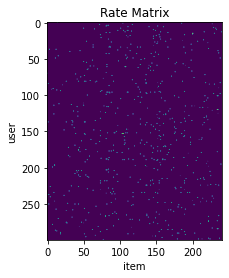

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
## 300 users x 241 items
plt.imshow(np_user_item_mat[:300])
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

### 4.2 Item-based CF by Surprise

Memory-based CF finds similarity between objects (either users or items) with the neighboring method. For Item-based CF, the object is defined as an item so that the system learns the interactions between items from current user's "behavior" to recommend the items similar to the items that current user have positively rated. KNN algorithm was introduced, but upgraded version of KNN (`KNNWithMeans()`) was used. While KNN naively finds the similar items (or user), `KNNWithMeans()` subtract the mean value of item (or user) ratings to modulate users' judgement based on mean rating just like the relationship between Cosine and Pearson similarities. It is important because each user has different createria of rating for items. An interesting fact is that Item-based CF works better than User-based one for the old items because item mean rating is not extremely affected by one user's rating whreas user mean rating is sensitive. 

In [14]:
## Use user_based true/false to switch between user-based or item-based collaborative filtering
knn = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [15]:
## run the trained model for the test_set
## uid: userID, iid: itemID, r_ui: rating that user gave for the item, est: rating estimation (prediction)
test_pred = knn.test(test_set)
test_pred[:2]

[Prediction(uid='A3KF2QPB634EIA', iid='B0015AARJI', r_ui=5.0, est=4.522388059701493, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2W1P0P5XCFA96', iid='B00IAVDOS6', r_ui=5.0, est=4.493459302325581, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})]

In [16]:
## run the trained model for the train_set
## uid: userID, iid: itemID, r_ui: rating that user gave for the item, est: rating estimation (prediction)
anti_testset = train_set.build_anti_testset()
anti_testset_pred = knn.test(anti_testset)
anti_testset_pred[:2]

[Prediction(uid='A32JCWTAULEMW6', iid='B00BI83EVU', r_ui=4.493459302325581, est=4.2152466367713, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A32JCWTAULEMW6', iid='B00DDXILBQ', r_ui=4.493459302325581, est=3.742857142857143, details={'actual_k': 0, 'was_impossible': False})]

In [17]:
## RMSE
print("Item-based Model : Test Set")
print("RMSE: ", rm.RMSE(test_pred))
print("MAE: ", rm.MAE(test_pred))
print()

print("Item-based Model : Train Set")
print("RMSE: ", rm.RMSE(anti_testset_pred))
print("MAE: ", rm.MAE(anti_testset_pred))

Item-based Model : Test Set
RMSE:  0.9884168840276029
MAE:  0.6422860068166297

Item-based Model : Train Set
RMSE:  0.45600920543561074
MAE:  0.2928807296711103


In [49]:
## pred for all data
all_pred = test_pred+anti_testset_pred
topN_pred = rm.GetTopN(all_pred, n=10)

## the top 1 predicted items for user A3KF2QPB634EIA
for userID, items in itertools.islice(topN_pred.items(), 1):
    print(x, y)


A2W1P0P5XCFA96 [('B00IAVDOS6', 4.493459302325581), ('B00503E8S2', 4.493459302325581)]


In [24]:
## Hit rate by using top 10 predictions
print("Hit Rate: ", rm.HitRate(topN_pred, test_pred))

Hit Rate:  0.4811943552782993


In [25]:
## Break down hit rate by rating value
print("rHR (Hit Rate by Rating value): ")
rm.RatingHitRate(topN_pred, test_pred)

rHR (Hit Rate by Rating value): 
1.0 0.47833333333333333
2.0 0.4231536926147705
3.0 0.413953488372093
4.0 0.3862736471623405
5.0 0.5076272591610015


In [26]:
## See how often we recommended a movie the user actually liked
print("cHR (Cumulative Hit Rate, rating >= 4): ")
rm.CumulativeHitRate(topN_pred, test_pred, 4.0)

cHR (Cumulative Hit Rate, rating >= 4): 


0.48838507150331356

In [27]:
## Compute ARHR
print("ARHR (Average Reciprocal Hit Rank): ")
rm.AverageReciprocalHitRank(topN_pred, test_pred)

ARHR (Average Reciprocal Hit Rank): 


0.4290059633164212

In [28]:
## Print user coverage with a minimum predicted rating of 4.0:
print("User coverage: ")
rm.UserCoverage(topN_pred, data_124.build_full_trainset().n_users, ratingThreshold=4.0)


User coverage: 


1.0

In [29]:
## Measure diversity of recommendations:
print("Diversity: ")
rm.Diversity(topN_pred, knn)


Diversity: 
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


0.9930513136511306

In [30]:
## ranking for items
rankings = rm.getPopularityRanks(amazon_ratings_124)

## Measure novelty (average popularity rank of recommendations):
print("Novelty (average popularity rank): ")
rm.Novelty(topN_pred, rankings)

Novelty (average popularity rank): 


96.03922989600859

In [31]:
def get_item_u(uid):
    """ 
    This outputs the number of items rated by given user
    Arguments: 
      uid -- the id of the user
    Return: 
      len(..) -- the number of items rated by the user
    """
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_user_i(iid):
    """ 
    This outputs number of users that have rated given item
    Arguments:
      iid -- the raw id of the item
    Return:
      len(..) -- the number of users that have rated the item.
    """
    try: 
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:
        return 0

## uid: userID, iid: itemID, r_ui: rating that user gave for the item, est: rating estimation (prediction)
df_test_pred = pd.DataFrame(test_pred, columns=['uid', 'iid', 'r_ui', 'pred', 'details'])
## num of items per user
df_test_pred['item_u'] = df_test_pred.uid.apply(get_item_u)
## num of users per item
df_test_pred['user_i'] = df_test_pred.iid.apply(get_user_i)
## error of prediction (estimation) 
df_test_pred['err'] = abs(df_test_pred.pred - df_test_pred.r_ui)
best_predictions = df_test_pred.sort_values(by='err')[:10]
worst_predictions = df_test_pred.sort_values(by='err')[-10:]

In [32]:
df_test_pred.shape

(16511, 8)

In [33]:
best_predictions

,uid,iid,r_ui,pred,details,item_u,user_i,err
2527,A17967PO5TLC9Y,B00YQ2KCWO,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,252,0.0
7404,A6SJJNQFDJVYJ,B00BMFIXOW,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",4,152,0.0
1507,A3VXF0FUYJDZST,B00GLZQR96,5.0,5.0,"{'actual_k': 3, 'was_impossible': False}",5,124,0.0
3929,AUVOMF6CMI4O6,B00DBDPOZ4,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,317,0.0
14268,ALB03N25CJDRO,B0053B5RGI,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,175,0.0
7397,A27I8YBSY7I1NM,B0053B66KE,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,168,0.0
10818,AGB8RJJ2LNAWR,B018K6KV68,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,90,0.0
14274,A8VIZIUX71XDI,B00MYTSDU4,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",2,300,0.0
8643,A2WVCV1NFR0R07,B0094X227I,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",5,236,0.0
10811,A2LKJU6P6LFD2L,B018K6KV68,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,90,0.0


In [34]:
worst_predictions

,uid,iid,r_ui,pred,details,item_u,user_i,err
8259,A1GV8GSI42JWSL,B00HD4R5YU,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,143,4.0
12602,A19UQJRSC30TPV,B00GMFKYJ4,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",1,116,4.0
9159,AI1CKS72N1BGR,B00F27JGVA,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,169,4.0
2662,A3U11UX5Q74LE2,B00PV515DU,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",3,106,4.0
15747,A1SGQ98X94B0ER,B00503E8S2,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",1,120,4.0
16283,AOZA4C7UNXVZD,B00BI9MDSO,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",4,93,4.0
15009,A15JPYV0L19RF,B00GMFKYK8,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",7,231,4.0
14876,A2B9MQBB1YZTAW,B00PE1KNPC,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",3,87,4.0
11833,A1C0ZIUIDOU3D9,B00Z7V9P8K,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",2,209,4.0
4441,A3974P9DBFTNOQ,B006JKARN0,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",1,87,4.0


In [35]:
view_AJEX9VERGX0YQ = df_test_pred[df_test_pred['uid']=='AJEX9VERGX0YQ'].sort_values(by='err')
view_AJEX9VERGX0YQ

,uid,iid,r_ui,pred,details,item_u,user_i,err
9786,AJEX9VERGX0YQ,B00L3LQ1FI,1.0,4.822222,"{'actual_k': 0, 'was_impossible': False}",2,90,3.822222
12235,AJEX9VERGX0YQ,B00DD0B0BM,1.0,5.000000,"{'actual_k': 2, 'was_impossible': False}",2,252,4.000000


In [36]:
## reviews of AJEX9VERGX0YQ
print("#"*20)
print("# Reviews of AJEX9VERGX0YQ")
print("#"*20)
for idx, item_raing in enumerate(topN_pred['AJEX9VERGX0YQ']):
    itemID, rating = item_raing
    print(f"item{idx}: {itemID}, Rating: {rating}")

####################
# Reviews of AJEX9VERGX0YQ
####################
item0: B00DD0B0BM, Rating: 5
item1: B0053B66KE, Rating: 5
item2: B004RMK57U, Rating: 5
item3: B00KWFCSB2, Rating: 5
item4: B00DC7G2W8, Rating: 5
item5: B00N4ABT1C, Rating: 5
item6: B00BU3ZLJQ, Rating: 5
item7: B00PB9LZQI, Rating: 5
item8: B0094X227I, Rating: 5
item9: B0094X2066, Rating: 5


### 4.2 User-based CF by Surprise + Impact of Distance Metrics

As mentioned, the performance of Memory-based (neighboring) CF is affected by distance metrics. In here, we will compare Cosine, Pearson, Mean Squared Difference based on naive KNN algorithm with 3-fold cross validation.

In [37]:
## similiarity options 
sim_options = {'name': 'cosine', 'user_based': True}
knn = surprise.KNNBasic(sim_options=sim_options)
cos_knn = surprise.model_selection.validation.cross_validate(knn, data_124, 
                                                   measures=[u'rmse', u'mae'], 
                                                   cv=3, return_train_measures=False, 
                                                   n_jobs=1, pre_dispatch=u'2*n_jobs', 
                                                   verbose=True)
cos_knn["test_rmse"].mean()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0498  1.0337  1.0530  1.0455  0.0085  
MAE (testset)     0.7110  0.7026  0.7061  0.7066  0.0035  
Fit time          53.08   50.41   49.78   51.09   1.43    
Test time         3.19    2.62    2.59    2.80    0.28    


1.0455117627195005

In [38]:
## similiarity options 
sim_options = {'name': 'pearson', 'user_based': True}
knn = surprise.KNNBasic(sim_options=sim_options)
prs_knn = surprise.model_selection.validation.cross_validate(knn, data_124, 
                                                   measures=[u'rmse', u'mae'], 
                                                   cv=3, return_train_measures=False, 
                                                   n_jobs=1, pre_dispatch=u'2*n_jobs', 
                                                   verbose=True)
prs_knn["test_rmse"].mean()

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9871  1.0012  1.0196  1.0026  0.0133  
MAE (testset)     0.7319  0.7354  0.7439  0.7371  0.0050  
Fit time          76.34   76.04   62.80   71.73   6.31    
Test time         4.07    2.47    2.30    2.94    0.80    


1.0026354699119138

In [39]:
## similiarity options 
sim_options = {'name': 'msd', 'user_based': True}
knn = surprise.KNNBasic(sim_options=sim_options)
prs_knn = surprise.model_selection.validation.cross_validate(knn, data_124, 
                                                   measures=[u'rmse', u'mae'], 
                                                   cv=3, return_train_measures=False, 
                                                   n_jobs=1, pre_dispatch=u'2*n_jobs', 
                                                   verbose=True)
prs_knn["test_rmse"].mean()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0274  1.0290  0.9986  1.0183  0.0140  
MAE (testset)     0.6712  0.6747  0.6520  0.6660  0.0100  
Fit time          47.29   43.03   43.57   44.63   1.89    
Test time         4.02    3.26    4.19    3.82    0.40    


1.0183482417730776

Since the KNN with pearson similarity was the best so far, predict 

In [34]:
train_set.all_items()

range(0, 241)

In [40]:
## Use user_based true/false to switch between user-based or item-based collaborative filtering
knn_basic = surprise.KNNBasic(k=5, sim_options={'name': 'pearson', 'user_based': True})
knn_basic.fit(train_set)



Computing the pearson similarity matrix...
Done computing similarity matrix.


In [42]:
testset_pred = knn_basic.test(anti_testset)

In [43]:
## run the trained model for the train_set
## uid: userID, iid: itemID, r_ui: rating that user gave for the item, est: rating estimation (prediction)
anti_testset_pred = knn_basic.test(anti_testset)


In [45]:
## User-based RMSE
print("User-based Model : Test Set")
print("RMSE: ", rm.RMSE(test_pred))
print("MAE: ", rm.MAE(test_pred))
print()

print("User-based Model : Train Set")
print("RMSE: ", rm.RMSE(anti_testset_pred))
print("MAE: ", rm.MAE(anti_testset_pred))

User-based Model : Test Set
RMSE:  0.9884168840276029
MAE:  0.6422860068166297

User-based Model : Train Set
RMSE:  0.0577801583787353
MAE:  0.0024057642733577036


Compared it to our Item-based model, RMSE result seems similar but the gap of RMSE between train_set and test_set tells that and Item-based seems a little bit better based on RMSE even though algorithm is slightly different (KNN with Mean for Item-based and KNN for User-based). This is bacause such a large gap causes overfitting issue. Of course, more testing is required to verify the overall error. 

In [47]:
## pred for all data
all_pred_user_based = test_pred+anti_testset_pred
topN_pred_user_based = rm.GetTopN(all_pred_user_based, n=10)

## the top 1 predicted items for user A3KF2QPB634EIA
for userID, items in itertools.islice(topN_pred_user_based.items(), 1):
    print(x, y)

A2W1P0P5XCFA96 [('B00IAVDOS6', 4.493459302325581), ('B00503E8S2', 4.493459302325581)]


In [50]:
## Hit rate by using top 10 predictions
print(f"Hit Rate: \n {rm.HitRate(topN_pred_user_based, test_pred)}\n\n")

## Break down hit rate by rating value
print("rHR (Hit Rate by Rating value): \n ")
rm.RatingHitRate(topN_pred_user_based, test_pred)

## See how often we recommended a movie the user actually liked
print(f"cHR (Cumulative Hit Rate, rating >= 4): \n {rm.CumulativeHitRate(topN_pred_user_based, test_pred, 4.0)}\n\n")

## Compute ARHR
print(f"ARHR (Average Reciprocal Hit Rank): \n {rm.AverageReciprocalHitRank(topN_pred_user_based, test_pred)}\n\n")

## Print user coverage with a minimum predicted rating of 4.0:
print(f"User coverage: \n {rm.UserCoverage(topN_pred_user_based, data_124.build_full_trainset().n_users, ratingThreshold=4.0)}\n\n")

## Measure diversity of recommendations:
print(f"Diversity: \n {rm.Diversity(topN_pred_user_based, knn_basic)}\n\n")

## ranking for items
#rankings = rm.getPopularityRanks(amazon_ratings_124)

## Measure novelty (average popularity rank of recommendations):
print("Novelty (average popularity rank): ")
rm.Novelty(topN_pred_user_based, rankings)


Hit Rate: 
 0.7866876627702744


1.0 0.6633333333333333
2.0 0.6107784431137725
3.0 0.6297674418604651
4.0 0.6555213374395072
5.0 0.8388326977284033
rHR (Hit Rate by Rating value): 
 None


cHR (Cumulative Hit Rate, rating >= 4): 
 0.80976630624346


ARHR (Average Reciprocal Hit Rank): 
 0.6729350947372306


User coverage: 
 1.0


Computing the pearson similarity matrix...
Done computing similarity matrix.
Diversity: 
 0.9995115147095422


Novelty (average popularity rank): 


100.70559587277776

In [36]:
print("#"*20)
print("# Baseline: KNN + pearson")
print("#"*20)
## similiarity options 
sim_options = {'name': 'pearson'}
knn = surprise.KNNBasic(sim_options=sim_options)
knn.fit(train_set)


####################
# Baseline: KNN + pearson
####################
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [37]:
# run the trained model against the testset
test_pred = knn.test(test_set)
test_pred[:3]

[Prediction(uid='A3KF2QPB634EIA', iid='B0015AARJI', r_ui=5.0, est=4.493459302325581, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='A2W1P0P5XCFA96', iid='B00IAVDOS6', r_ui=5.0, est=4.493459302325581, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AB2FYWHOGTRGF', iid='B0011E4J2Y', r_ui=5.0, est=4.493459302325581, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})]

In [38]:
df_test_pred = pd.DataFrame(test_pred, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
df_test_pred['item_u'] = df_test_pred.uid.apply(get_item_u)
df_test_pred['user_i'] = df_test_pred.iid.apply(get_user_i)
df_test_pred['err'] = abs(df_test_pred.est - df_test_pred.r_ui)
best_predictions = df_test_pred.sort_values(by='err')[:10]
worst_predictions = df_test_pred.sort_values(by='err')[-10:]



In [39]:
B0015AARJI_iid = knn.trainset.to_inner_iid('B0015AARJI')
print(f"{B0015AARJI_iid} <-> {knn.trainset.to_raw_iid(B0015AARJI_iid)}")

125 <-> B0015AARJI


In [40]:
knn.trainset.to_raw_iid(216)

'B0050SYV70'

In [41]:
B0015AARJI_neighbors

<generator object <genexpr> at 0x11ef18890>

In [42]:
B0015AARJI_inner_id = knn.trainset.to_inner_iid('B0015AARJI')

# Retrieve inner ids of the nearest neighbors of B000FNFSPY
B0015AARJI_rawiids_neighbors = knn.get_neighbors(B0015AARJI_inner_id, k=5)

# Convert inner ids of the neighbors into names.
B0015AARJI_neighbors = (knn.trainset.to_raw_iid(inner_id) for inner_id in B0015AARJI_rawiids_neighbors) 

print('The 5 nearest neighbors of B0015AARJI:')
for item in B0015AARJI_neighbors:
    print(item)

The 5 nearest neighbors of B0015AARJI:
B00C27SCC2


ValueError: 334 is not a valid inner id.

## Model-based collaborative filtering system
These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [ ]:
user_item_mat.shape

In [69]:
item_user_mat = user_item_mat.T
print(item_user_mat.shape)
item_user_mat.head(3)

(241, 23789)


reviewerID,A0220159ZRNBTRKLG08H,A0277912HT4JSJKVSL3E,A02836981FYG9912C66F,A03622674FSWUX0PXPAK,A0380485C177Q6QQNJIX,A0435554Z2P98AIGLNCS,A049248150WLX2UGA57G,A0667676ELTQ9GS4VZHH,A0685888WB02Q69S553P,A0695568PX4DBZOQDN8,...,AZYSLPX9HUWPW,AZYUJNUA38IYL,AZYUNW5G2R3CL,AZYWRH9CQSB2Q,AZZ1KF8RAO1BR,AZZ2RPY63LR0B,AZZDDQSI60WTM,AZZQCK9ZAKMFR,AZZT1ERHBSNQ8,AZZTOUKVTUMVM
asin,,,,,,,,,,,,,,,,,,,,,
B0009VXBAQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000B9RI14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000ERVMI8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
## Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(item_user_mat)
decomposed_matrix.shape

(241, 10)

In [71]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(241, 241)

Index # of item ID purchased by customer

In [83]:
amazon_ratings_124[amazon_ratings_124['asin'] == 'B0015AARJI']#.iloc[:3]

,reviewerID,asin,overall
3091,A7AQG5H1RB0NY,B0015AARJI,5.0
3092,A1J77AZSA076EF,B0015AARJI,5.0
3093,A123NX4VM0U422,B0015AARJI,5.0
3094,A1D8TXQNAJWTYS,B0015AARJI,5.0
3095,AFMAZRGEWTQB0,B0015AARJI,5.0
...,...,...,...
3464,A1172RQH5UKH43,B0015AARJI,5.0
3465,A2ZF0HRAX6SNUW,B0015AARJI,5.0
3466,A3M4FM3FPUAZ5I,B0015AARJI,5.0
3467,A2ZTUOL4G3OPDL,B0015AARJI,5.0


In [84]:
amazon_ratings_124[amazon_ratings_124['reviewerID'] == 'A7AQG5H1RB0NY']

,reviewerID,asin,overall
3091,A7AQG5H1RB0NY,B0015AARJI,5.0
49259,A7AQG5H1RB0NY,B006JKARN0,5.0


In [79]:
## Counts for ratings per user in descending order.
user_num_mean = amazon_ratings_124.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
user_num_mean = pd.DataFrame(user_num_mean)
## rename
user_num_mean.rename(columns={'overall':'num_ratings'}, inplace=True)
## Calculate mean of ratings for each user.
user_num_mean['mean_rating'] = amazon_ratings_124.groupby(by='reviewerID')['overall'].apply(np.mean)

print(f": {len(user_num_mean)}")
user_num_mean.head(10)


: 23789


,num_ratings,mean_rating
reviewerID,,
A14KKV5U5XSHXY,69,5.000000
A1RS06313BL6WN,42,4.166667
A71Z5AIGEFK11,40,5.000000
AJV2L53BJLNUA,27,4.296296
A361MDDVW2JW39,22,5.000000
A33LP81Z6FCC73,21,5.000000
A230RAOOP9XBN5,21,5.000000
A18PM7A5VL8FD2,20,4.100000
A31GWUD5AUE54T,20,3.850000


In [85]:
user_item_mat[user_item_mat.index=='A7AQG5H1RB0NY']

asin,B0009VXBAQ,B000B9RI14,B000ERVMI8,B000FO4KO8,B000FQ9R4E,B000FRU0NU,B000FRU1UM,B000HZFCT2,B000IMYKQ0,B000P46NMA,...,B018K6KV68,B019J6RYCW,B019OB663A,B01C93CWSI,B01C93CWU6,B01F9HMO2K,B01GKGVI8U,B01GW3ODBU,B01GW3P9PE,B01GW3POY0
reviewerID,,,,,,,,,,,,,,,,,,,,,
A7AQG5H1RB0NY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
user_item_mat.index[170]

'A10QW6BAIUL7D1'

In [135]:
## item B0014HMAZQ
item_user_mat.index[170]

'B004RORMF6'

In [134]:
amazon_ratings_39[amazon_ratings_39['reviewerID'] == 'A4GGT6O0GQNV2']

,reviewerID,asin,overall
170,A4GGT6O0GQNV2,B000FNFSPY,5.0
2133,A4GGT6O0GQNV2,B00FNPD1VW,5.0
5220,A4GGT6O0GQNV2,B001V59KR2,3.0
7348,A4GGT6O0GQNV2,B00KYK2AKO,5.0
13216,A4GGT6O0GQNV2,B00001P4ZH,5.0
24635,A4GGT6O0GQNV2,B0002H02ZY,5.0
28500,A4GGT6O0GQNV2,B00JR625WO,5.0
29939,A4GGT6O0GQNV2,B00CD8AFFW,5.0


In [86]:
item = "B0015AARJI"

item_IDs = list(item_user_mat.index)
item_idx = item_IDs.index(item)
item_idx

23

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [91]:
correlation_B0015AARJI = correlation_matrix[item_idx]
correlation_B0015AARJI.shape


(241,)

Recommending top 25 highly correlated products in sequence

In [94]:
recommended_items = list(item_user_mat.index[correlation_B0015AARJI > 0.85])

# Removes the item already bought by the customer
recommended_items.remove(item) 

recommended_items[0:24]

['B0009VXBAQ',
 'B000FO4KO8',
 'B000P46NMA',
 'B000S0C2UI',
 'B000TLU67W',
 'B000VTQ3LU',
 'B000ZK9QCS',
 'B0012N94WO',
 'B0017ZIIK6',
 'B0050SYV70',
 'B006JKARN0',
 'B006ZTHFPS',
 'B00BMFIXT2',
 'B00CRL9TU2',
 'B00JA81WQE',
 'B00JQHU9RC']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.

In [ ]:
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True) # split data into folds.

In [ ]:
aaa